In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [0]:
!pip install statsmodels

Getting our data and looking through the columns  

In [0]:
data = pd.read_csv('insurance.csv')

In [6]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We have a target **(charges)** and 6 features. In the begging we'll make EDA (explore which features we should use, whether there are Nan values and etc.)

In [7]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


We have no missing values and that great!

In [8]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Let's look at the **outliers**. If we have them, then we should remove.

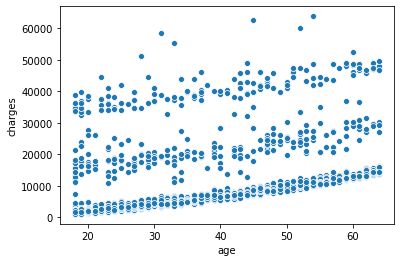

In [9]:
sns.scatterplot(y=data.charges, x=data.age) # there are some at the charges of 50,000 and higher

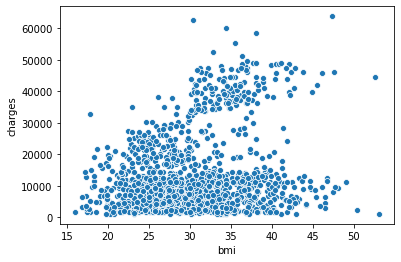

In [10]:
sns.scatterplot(y=data.charges, x=data.bmi) # there are some at the charges of 55,000 and higher

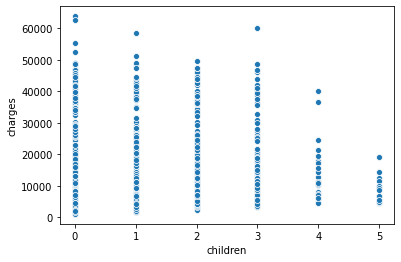

In [11]:
sns.scatterplot(y=data.charges, x=data.children) # there are some at the charges of 55,000 and higher

So let's remove charges above 55,000.

In [12]:
data[data.charges>55000]

,age,sex,bmi,children,smoker,region,charges
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


In [0]:
data = data.drop(data[data.charges>55000].index)

In [14]:
data.shape

(1333, 7)

When we look at the distribution of our target (**charges**) it has skewness. Let's take log of the target to make it look more like a normal distribution.

---



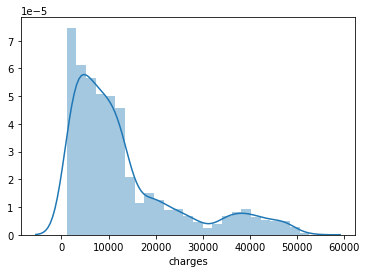

In [15]:
sns.distplot(data.charges)

In [17]:
from scipy.stats import kurtosis
from scipy.stats import skew
print('Skewness: {}, kurtosis: {}'.format(skew(data.charges), kurtosis(data.charges)))

Skewness: 1.4556754769102132, kurtosis: 1.272300224454872


In [0]:
data['log_charges'] = np.log(data.charges)

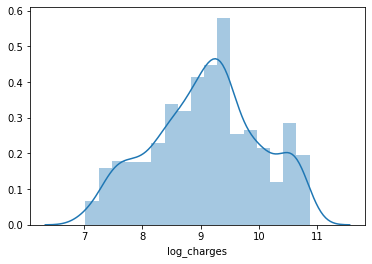

In [22]:
sns.distplot(data.log_charges)

Much better!

In [20]:
print('Skewness: {}, kurtosis: {}'.format(skew(data.log_charges), kurtosis(data.log_charges)))

Skewness: -0.10256011481080615, kurtosis: -0.6445237482389592


We've done with the target. Let's start with feature preprocessing. In the dataset there are less smokers, approximately the same number of male and female. As you see region's distribution doesnt't differ much. But we'll back to it in our correlation matrix.

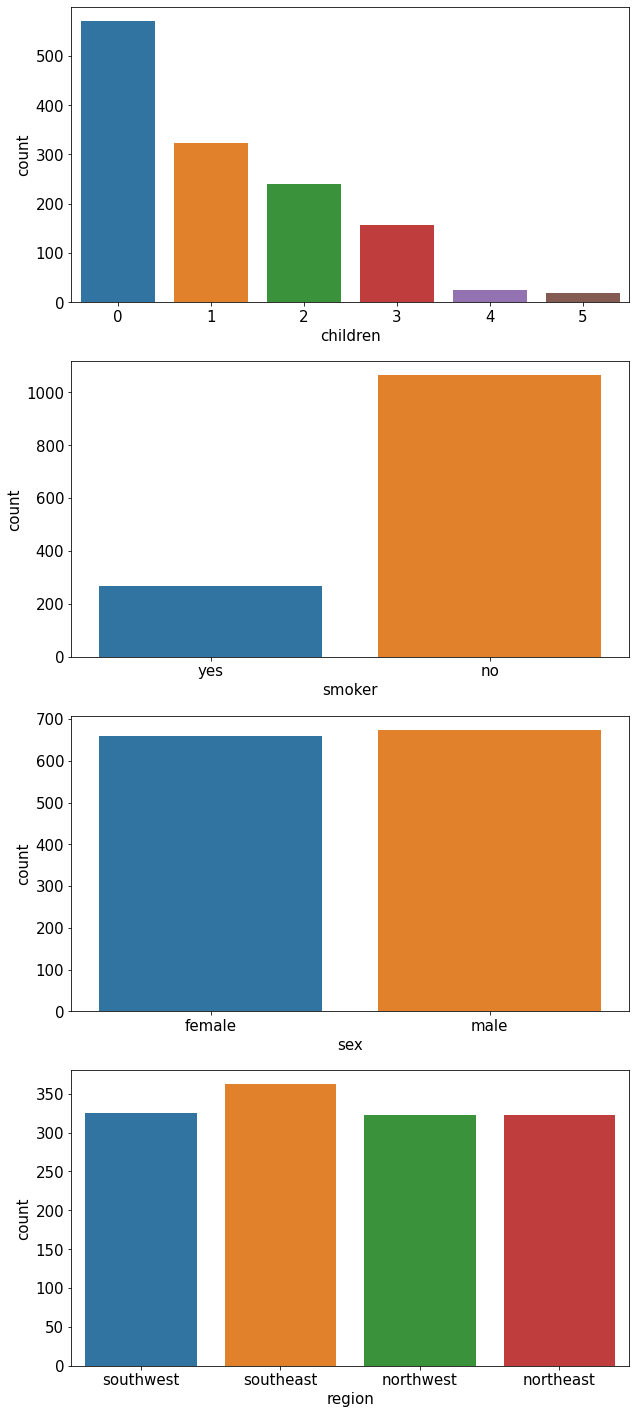

In [555]:
features = ['children','smoker','sex','region']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 25))
for idx, f in enumerate(features):
  sns.countplot(data[f], ax=axes[idx])
  axes[idx].set_xlabel(size = 15, xlabel=f)
  axes[idx].set_ylabel(size = 15, ylabel='count')
  axes[idx].tick_params(axis='both', labelsize=15)
plt.show()

Now le's look at the **age**, which is also a continuous variable. At first we must normalize it. 

Skewness: 0.057429174455533166, kurtosis: -1.2458850561030326


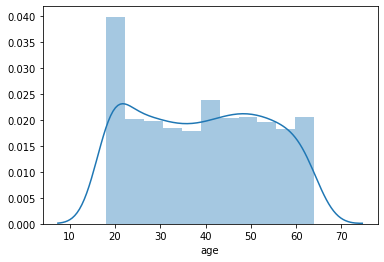

In [23]:
sns.distplot(data.age)
print('Skewness: {}, kurtosis: {}'.format(skew(data.age), kurtosis(data.age)))

In [0]:
def normalize(feature):
  normalized_feature = (feature - np.mean(feature)) / np.std(feature)
  return normalized_feature

In [0]:
data['age_norm'] = normalize(data.age)

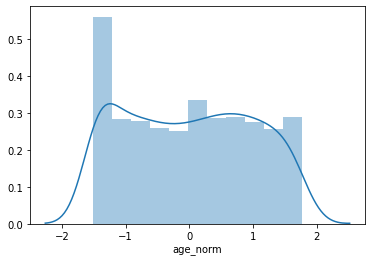

In [31]:
sns.distplot(data.age_norm)

For deeper visualisation let's cut **age** into bins. So the minimum age is 18 and the maximum is 64. I've cut age into 5 bins.

In [0]:
labels = ['adolescent','young_adult','middle_adult', 'old_person']
bins = [17, 20, 35, 50, 65]
data['age_binned']=pd.cut(data.age, bins=bins, labels=labels)

And the last feature is **bmi**. And its distribution perfectly resembles normal distibution. I've normalized it also. 

Skewness: 0.28089613013374637, kurtosis: -0.06201919401529832


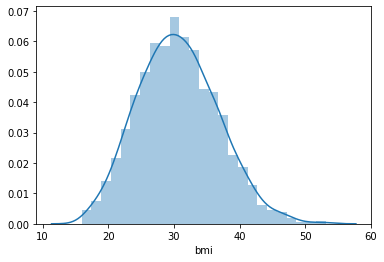

In [38]:
sns.distplot(data.bmi)
print('Skewness: {}, kurtosis: {}'.format(skew(data.bmi), kurtosis(data.bmi)))

In [0]:
data['bmi_norm'] = normalize(data.bmi)

Perhaps, we can improve our model if we cut bmi into bins as age too. And if we come back to the description of dataset we'll find out that the min value of mbi is 15.6 (underweight) and max - 53 (high obesity).

In [0]:
labels_bmi = ['underweight', 'healthy', 'overweight', 'obesity']
bins_bmi = [0, 18.5, 24.9, 29.9, 60]
data['bmi_binned'] = pd.cut(data.bmi, bins=bins_bmi, labels=labels_bmi)

In [253]:
data.loc[:,['bmi','bmi_binned']]

,bmi,bmi_binned
0,27.900,overweight
1,33.770,obesity
2,33.000,obesity
3,22.705,healthy
4,28.880,overweight
...,...,...
1333,30.970,obesity
1334,31.920,obesity
1335,36.850,obesity
1336,25.800,overweight


To sum up, in the dataset we have twice higher people with obesity than with healty weight. The role of smoking isn't significant and adolescents tend to suffer less from obesity.

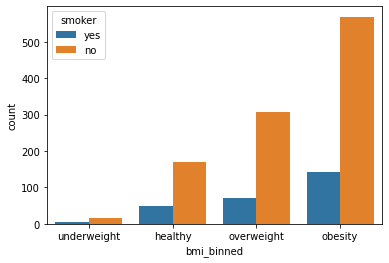

In [43]:
sns.countplot(data.bmi_binned, hue=data.smoker)

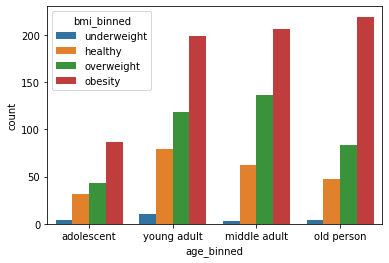

In [45]:
sns.countplot(data.age_binned, hue=data.bmi_binned)

And let's make **children** feature more specific. If someone has 1 and more children, than - 'yes', if not - 'no'. Because I don't think that the amount of children plays a big role in charges.

In [0]:
labels_children = ['no', 'yes']
bins_children = [0,1,6]
data['have_children'] = pd.cut(data.children, bins=bins_children, labels=labels_children, right=False)

And you can see that adults tend to have children (of course it's obvious).

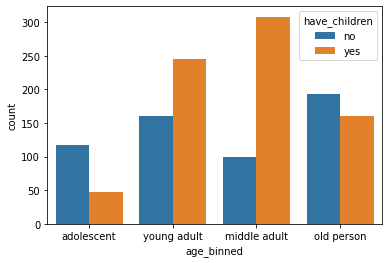

In [48]:
sns.countplot(data.age_binned, hue=data.have_children)

By far we've expanded our dataset. The last step is to convert categotical features into numerical and choose which features we are going to use to train our model.

In [50]:
data.dtypes

age                 int64
sex                object
bmi               float64
children            int64
smoker             object
region             object
charges           float64
log_charges       float64
age_norm          float64
age_binned       category
bmi_norm          float64
bmi_binned       category
have_children    category
dtype: object

In [0]:
y = data.log_charges #let's extract our target and delete log_charges and chrages from dataset

In [0]:
data.drop(['log_charges', 'charges'], axis=1, inplace=True)

In [0]:
cat_features = data.select_dtypes(include=['object','category'])
num_features = data.select_dtypes(include=['int64', 'float64'])

In [62]:
num_features.head()

,age,bmi,children,age_norm,bmi_norm
0,19,27.900,0,-1.436484,-0.450173
1,18,33.770,1,-1.507623,0.514611
2,28,33.000,3,-0.796238,0.388055
3,33,22.705,0,-0.440546,-1.304015
4,32,28.880,0,-0.511684,-0.289101


I'll drop **children** (because I think it's less important than feature **have_children**), **bmi** and **age** - as we have normalized these features.

In [0]:
num_features = num_features.iloc[:, 3:]

In [255]:
num_features.head()

,age_norm,bmi_norm
0,-1.436484,-0.450173
1,-1.507623,0.514611
2,-0.796238,0.388055
3,-0.440546,-1.304015
4,-0.511684,-0.289101


Now categorical features. We'll drop **region** and make dummy variables for the other categorical features.

In [0]:
cat_features.drop('region', axis=1, inplace=True)

In [304]:
cat_features.head()

,sex,smoker,have_children,age_binned,bmi_binned
0,female,yes,no,adolescent,overweight
1,male,no,yes,adolescent,obesity
2,male,no,yes,young_adult,obesity
3,male,no,no,young_adult,healthy
4,male,no,no,young_adult,overweight


We'll try two models: 1st - where features **bmi_binned** and **age_binned** are taken into account and our data will represent sparse matrix, 2nd - they don't. Because on the one hand these features expand our model and we may have for instance high R2 score, on the other hand we may have multicollinearity (for instance between **age** and different **age_binned**).

In [0]:
cat_features_1 = cat_features.drop(['age_binned', 'bmi_binned'], axis=1)

In [0]:
cat_features_1 = pd.get_dummies(cat_features_1, drop_first=True)

In [305]:
cat_features_1.head()

,sex_male,smoker_yes,have_children_yes
0,0,1,0
1,1,0,1
2,1,0,1
3,1,0,0
4,1,0,0


In [0]:
cat_features_2 = pd.get_dummies(cat_features, drop_first=True)

In [308]:
cat_features_2.head()

,sex_male,smoker_yes,have_children_yes,age_binned_young_adult,age_binned_middle_adult,age_binned_old_person,bmi_binned_healthy,bmi_binned_overweight,bmi_binned_obesity
0,0,1,0,0,0,0,0,1,0
1,1,0,1,0,0,0,0,0,1
2,1,0,1,1,0,0,0,0,1
3,1,0,0,1,0,0,1,0,0
4,1,0,0,1,0,0,0,1,0


In [0]:
X_1 = pd.concat([cat_features_1, num_features], axis=1)

In [0]:
X_2 = pd.concat([cat_features_2, num_features], axis=1)

Here we have fully numerical train data. Let's look at the correlation matrix.

In [264]:
X_1.head()

,sex_male,smoker_yes,have_children_yes,age_norm,bmi_norm
0,0,1,0,-1.436484,-0.450173
1,1,0,1,-1.507623,0.514611
2,1,0,1,-0.796238,0.388055
3,1,0,0,-0.440546,-1.304015
4,1,0,0,-0.511684,-0.289101


In [0]:
corr_matrix1 = pd.concat([X_1, y], axis=1)
corr_matrix2 = pd.concat([X_2, y], axis=1)

In [0]:
mask1 = np.zeros_like(corr_matrix1.corr())
mask1[np.triu_indices_from(mask1)] = True

In [0]:
mask2 = np.zeros_like(corr_matrix2.corr())
mask2[np.triu_indices_from(mask2)] = True

Analyzing two correlation matrices we can conclude: 1) there's no corr between target and **sex** feature in both matrices;  2) as I thought, in the 2nd model we have correlation between its features (**age_norm** and **bmi_norm** have above the average corr with some **age_binned** and **bmmi_binned** features).

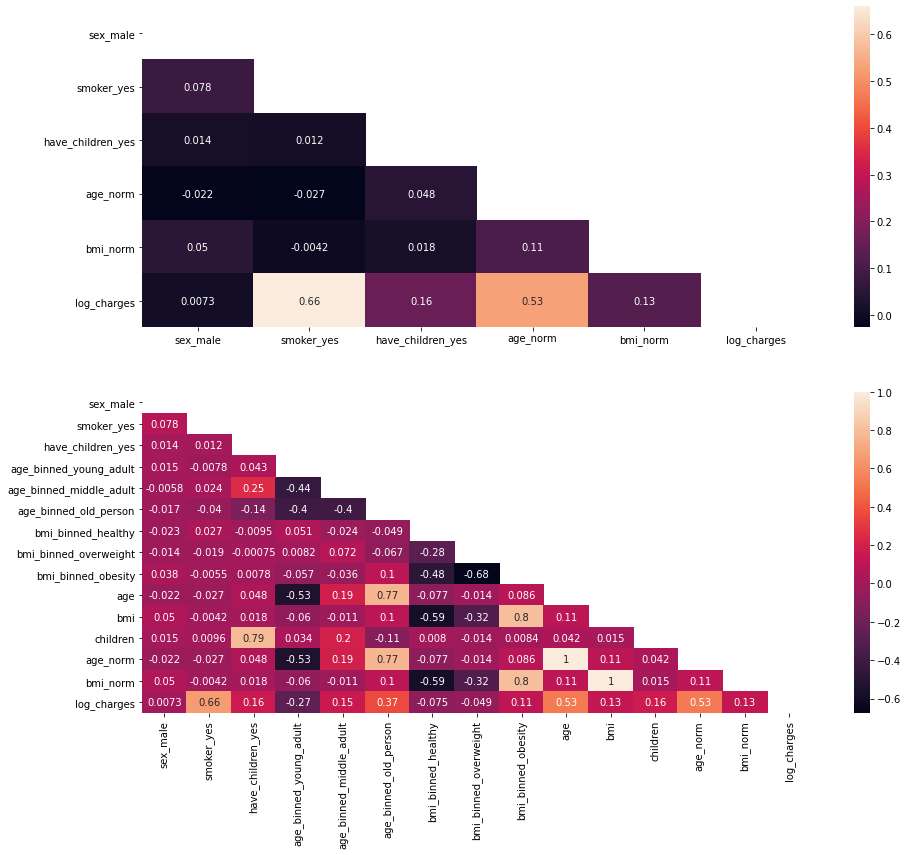

In [312]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 13))
sns.heatmap(corr_matrix1.corr(), annot=True, mask=mask1, ax=axes[0])
sns.heatmap(corr_matrix2.corr(), annot=True, mask=mask2, ax=axes[1])

Just for an experiment we can add some interactions between features and look again at the corr_matrix.

We're ready for the 2nd part - **building a model**. We'll use train_test_split and try different models with tuning. Also we'll make statistical tests to choose between two models. Unfrotunately, we don't have much data to be sure that our predictions will be correct, but we'll see it.

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [0]:
import statsmodels.api as sm 

We'll start with **model_1**.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size = 0.25, random_state=42) 

In [274]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((999, 5), (334, 5), (334,), (999,))

In [0]:
X = sm.add_constant(X_train)

In [0]:
model_1 = sm.OLS(y_train, X)

We have: **R^2 score** (0.75) isn't big; all coeffs are significant, but **sex_male** p-value is significant only at 0.05 level;

In [292]:
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     598.2
Date:                Fri, 29 May 2020   Prob (F-statistic):          1.46e-296
Time:                        11:26:54   Log-Likelihood:                -629.32
No. Observations:                 999   AIC:                             1271.
Df Residuals:                     993   BIC:                             1300.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.6898      0.02

Let's add some interactions.

In [0]:
train_data = pd.concat([X_train, y], axis=1) 

In [0]:
model_1_inter = sm.OLS.from_formula('log_charges~ sex_male+smoker_yes+smoker_yes:bmi_norm+age_norm*have_children_yes', data=train_data)

In [344]:
results_1_inter = model_1_inter.fit()
print(results_1_inter.summary()) #R2 is a little higher

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     561.8
Date:                Fri, 29 May 2020   Prob (F-statistic):          6.64e-315
Time:                        12:13:10   Log-Likelihood:                -583.46
No. Observations:                 999   AIC:                             1181.
Df Residuals:                     992   BIC:                             1215.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

So at the significance level of 0.05 we reject hypothesis that model without interactions is better.

In [345]:
results_1_inter.compare_f_test(results_1) 

(95.39702413930692, 1.4087788966876785e-21, 1.0)

Now **model_2**.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size = 0.25, random_state=42) 

In [0]:
X = sm.add_constant(X_train)

2nd model has some insignificant values and we have a warning of multicollinearity.

In [352]:
model_2 = sm.OLS(y_train, X)
results_2 = model_2.fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     257.2
Date:                Fri, 29 May 2020   Prob (F-statistic):          1.24e-293
Time:                        12:18:11   Log-Likelihood:                -614.75
No. Observations:                 999   AIC:                             1255.
Df Residuals:                     986   BIC:                             1319.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Our p-value is 1.0! Which tells us the **model_1** with interactions is better than the **model_2**.

In [354]:
results_2.compare_f_test(results_1_inter) 

(-9.978242365847223, 1.0, 6.0)

Let's add interactions to our train data and try different estimators.

In [355]:
results_1_inter.params

Intercept                     8.699309
sex_male                     -0.077137
smoker_yes                    1.542305
smoker_yes:bmi_norm           0.306599
age_norm                      0.546184
have_children_yes             0.219090
age_norm:have_children_yes   -0.130625
dtype: float64

In [356]:
X_1.keys()

Index(['sex_male', 'smoker_yes', 'have_children_yes', 'age_norm', 'bmi_norm'], dtype='object')

In [0]:
X_1['smoker_yes:bmi_norm'] = X_1.smoker_yes*X_1.bmi_norm
X_1['age_norm:have_children_yes'] = X_1.age_norm*X_1.have_children_yes

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X_1, y, test_size=0.25, random_state=42)

We'll start with **Ridge** and **KernelRidge** regressions to see whether we need penalty or not. We'll use **RMSE** and **R^2 score** as a metric. **RMSE** is 0.3654, not bad.

In [387]:
model = Ridge().fit(x_train, y_train)
y_pred = model.predict(x_test)
np.sqrt(mean_squared_error(y_test, p)), r2_score(y_test, y_pred)

(0.3654748683147421, 0.7901788352352546)

In [0]:
params_1 = {
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [1, 0.7, 0.5],
    'degree': [2,3]
}
grid_1 = GridSearchCV(KernelRidge(), params_1, scoring='neg_root_mean_squared_error', cv=5).fit(x_train, y_train)

In [391]:
grid_1.best_params_

{'degree': 2, 'gamma': 0.5, 'kernel': 'poly'}

**RMSE** is a little bit bigger, but **R^2** is higher.

In [392]:
y_pred_1 = grid_1.predict(x_test)
print('Loss: {}, R^2: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_1)), r2_score(y_test, y_pred_1)))

Loss: 0.36898750302664945, R^2: 0.8403658223368009


With **SVR** we have RMSE - 0.3635, which is a little bit smaller than with **Ridge** regression.

In [0]:
params_2 = {
    'kernel': ['poly', 'rbf'],
    'degree': [2,3],
    'gamma': [0.7, 0.5, 0.3],
    'C': [3, 5]  
}
grid_2 = GridSearchCV(SVR(), params_2, scoring='neg_root_mean_squared_error', cv=5).fit(x_train, y_train)

In [401]:
grid_2.best_params_

{'C': 3, 'degree': 2, 'gamma': 0.3, 'kernel': 'rbf'}

In [402]:
y_pred_2 = grid_2.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred_2)), r2_score(y_test, y_pred_2)

(0.363593808624486, 0.8449986349687342)

Now **RandomForest**. As you can see we have here RMSE - 0.3734 which is the worst results of all.

In [0]:
params_3 = {
    'max_depth':[3, 7, 10, 15],
    'n_estimators':[100,150,200, 170, 250],
    'max_features':['auto', 'log2', 'sqrt'],
    'min_samples_split': [2,3,5]
}
grid_3 = GridSearchCV(RandomForestRegressor(), params_3, scoring='neg_root_mean_squared_error', cv=5).fit(x_train, y_train)

In [375]:
grid_3.best_params_

{'max_depth': 7,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 200}

In [376]:
y_pred_3 = grid_3.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred_3)), r2_score(y_test, y_pred_3)

(0.3734854444816342, 0.8364502342631993)

And the last model will be **DNN**. I've different hyperparams and as teh result **RMSE** is a little bit higher in comparison with other results.

In [0]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
model_tf = Sequential()
model_tf.add(Dense(64,activation='relu',input_shape=[len(x_train.keys())]))
model_tf.add(Dense(64,activation='relu'))
model_tf.add(Dropout(0.2))
model_tf.add(Dense(1, activation='linear'))

model_tf.compile(loss='mse',optimizer='SGD',metrics=['RootMeanSquaredError'])

In [0]:
path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(path, 
                                      monitor='val_root_mean_squared_error',
                                      save_best_only=True,
                                      verbose=1)

In [0]:
model_tf.fit(x_train, y_train, batch_size=32, validation_split=0.2,epochs=50,
             callbacks=[checkpoint_callback])

In [0]:
model_tf.load_weights(path)

In [0]:
y_pred_4 = model_tf.predict(x_test)

In [449]:
np.sqrt(mean_squared_error(y_test, y_pred_4)), r2_score(y_test, y_pred_4)

(0.3653957626035253, 0.8434584688166881)

Here is the summary. For the final answer let's take the average of the last 4 models.

In [454]:
estimators = ['Ridge', 'KernekRidge', 'SVR', 'RandomForest', 'DNN']
predictions = [y_pred, y_pred_1, y_pred_2, y_pred_3, y_pred_4]
for i in range(5):
  print('Model: {}.\n RMSE: {:.4f}. R^2: {:.2f}. MAE: {:.2f}.'.format(estimators[i],
                                                        np.sqrt(mean_squared_error(y_test, predictions[i])),
                                                        r2_score(y_test, predictions[i]),
                                                        mean_absolute_error(y_test, predictions[i])))
  print()

Model: Ridge.
 RMSE: 0.4230. R^2: 0.79. MAE: 0.27.

Model: KernekRidge.
 RMSE: 0.3690. R^2: 0.84. MAE: 0.21.

Model: SVR.
 RMSE: 0.3636. R^2: 0.84. MAE: 0.18.

Model: RandomForest.
 RMSE: 0.3735. R^2: 0.84. MAE: 0.21.

Model: DNN.
 RMSE: 0.3654. R^2: 0.84. MAE: 0.21.



In [0]:
average_preds = np.column_stack((y_pred_1, y_pred_2, y_pred_3, y_pred_4))

In [470]:
average_preds = pd.DataFrame(average_preds, columns=['KernelRidge', 'SVR', 'RandomForest', 'DNN'])
average_preds.head()

,KernelRidge,SVR,RandomForest,DNN
0,10.864995,10.619151,10.710119,10.880288
1,9.027598,8.973079,8.958302,8.974766
2,8.777129,8.874236,8.918456,8.985731
3,10.424726,10.684245,10.522395,10.463915
4,8.571021,8.503308,8.570402,8.561272


In [0]:
preds = average_preds.mean(axis=1)

In [0]:
test = y_test.reset_index(drop=True)

In [502]:
print('Average RMSE with the best 4 models: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, preds))))

Average RMSE with the best 4 models: 0.3605


We may have a look at the real numbers of test and predicted values by taking exp.

In [497]:
test_predicted = pd.DataFrame({'Test y': np.exp(test),
                               'Predicted y': np.exp(preds)})
test_predicted.head()

,Test y,Predicted y
0,48673.5588,47507.280459
1,7045.4990,7969.969716
2,6474.0130,7250.950795
3,38746.3551,37190.927652
4,4463.2051,5174.514416


In [508]:
print('MAE for originall data is {:.0f}'.format(mean_absolute_error(test_predicted['Test y'], test_predicted['Predicted y'])))

MAE for originall data is 2052


# In conclusion we have:

1) we've tried different models and approches of preprocessing and the most 
important features for us were the age and smoking status;

2) the best **RMSE** was achieved by **SVR** regression and it's 0.3635;

3) the average **RMSE** is 0.3605;

4) our test and predicted values have  differance on average of 2052;

The reason for such imperfect results is  a poor amount of data. Even in real life it's difficult to predict person's charges having age, sex and bmi. For instance, we could improve our results if we had information about chronic diseases, job (builders risk their health), ecological situation (quality of water, pollution of the air) and etc.